# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.DataStructs import ConvertToNumpyArray

from rdkit.Chem import PandasTools

In [3]:
# Import PyTorch and its modules
import torch
import torchvision
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import shap

from sklearn.inspection import permutation_importance
import seaborn as sns # for correlation heatmap


# Load the data

In [5]:
#
#datapath = os.path.join(".", "tox21.csv")
tox21 = pd.read_csv("tox21.csv")
tox21.head()

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group
0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
1,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,train
2,O=C(Nc1c(cccc1C)C)C(N(CCC)CC)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,train
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,O(OC(C)(C)C)C(CCC(OOC(C)(C)C)(C)C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,train


## Data preprocessing

In [6]:
tox21.describe()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
count,7245.000000,6740.000000,6529.000000,5804.000000,6175.000000,6936.000000,6432.000000,5816.000000,7054.000000,6447.000000,5795.000000,6756.000000
mean,0.042650,0.035015,0.117323,0.051516,0.128421,0.050317,0.028762,0.161279,0.037284,0.057236,0.158240,0.062463
std,0.202081,0.183831,0.321829,0.221067,0.334585,0.218614,0.167151,0.367820,0.189470,0.232311,0.364997,0.242012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#Generate data exploration
tox21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 14 columns):
cano_smiles      7811 non-null object
NR-AR            7245 non-null float64
NR-AR-LBD        6740 non-null float64
NR-AhR           6529 non-null float64
NR-Aromatase     5804 non-null float64
NR-ER            6175 non-null float64
NR-ER-LBD        6936 non-null float64
NR-PPAR-gamma    6432 non-null float64
SR-ARE           5816 non-null float64
SR-ATAD5         7054 non-null float64
SR-HSE           6447 non-null float64
SR-MMP           5795 non-null float64
SR-p53           6756 non-null float64
group            7811 non-null object
dtypes: float64(12), object(2)
memory usage: 854.5+ KB


In [8]:
tox21.shape

(7811, 14)

In [9]:
#Returns number of unique values in the specifed column to make sure that no duplications there
tox21['cano_smiles'].nunique()

7806

In [10]:
#Returns number of total rows
tox21['cano_smiles'].count()

7811

In [11]:
#Drops the duplicated ones
tox21 = tox21.drop_duplicates(['cano_smiles'])

In [12]:
tox21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7806 entries, 0 to 7810
Data columns (total 14 columns):
cano_smiles      7806 non-null object
NR-AR            7240 non-null float64
NR-AR-LBD        6735 non-null float64
NR-AhR           6524 non-null float64
NR-Aromatase     5801 non-null float64
NR-ER            6171 non-null float64
NR-ER-LBD        6932 non-null float64
NR-PPAR-gamma    6427 non-null float64
SR-ARE           5812 non-null float64
SR-ATAD5         7049 non-null float64
SR-HSE           6442 non-null float64
SR-MMP           5792 non-null float64
SR-p53           6751 non-null float64
group            7806 non-null object
dtypes: float64(12), object(2)
memory usage: 914.8+ KB


## Molecule genaration

In [13]:
# Create Mol rdkit objects for each smile
PandasTools.AddMoleculeColumnToFrame(frame=tox21, smilesCol='cano_smiles', molCol='Molecule')

There are a couple of SMILES that could be parsed by RDKit. For wrong SMILES, rdkit would return 'None'.

In [14]:
sum(tox21['Molecule'].map(lambda x: x is None))

0

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group,Molecule
0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train,
1,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,train,
2,O=C(Nc1c(cccc1C)C)C(N(CCC)CC)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,train,
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,
4,O(OC(C)(C)C)C(CCC(OOC(C)(C)C)(C)C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,train,

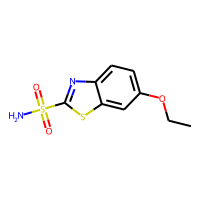
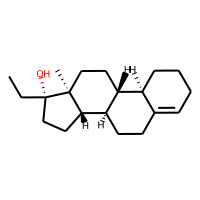
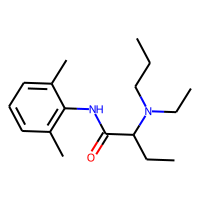
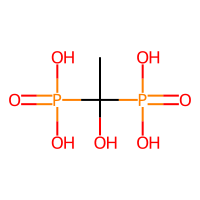
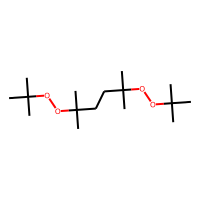

In [15]:
tox21.head()

In [16]:
#Generate data exploration
tox21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7806 entries, 0 to 7810
Data columns (total 15 columns):
cano_smiles      7806 non-null object
NR-AR            7240 non-null float64
NR-AR-LBD        6735 non-null float64
NR-AhR           6524 non-null float64
NR-Aromatase     5801 non-null float64
NR-ER            6171 non-null float64
NR-ER-LBD        6932 non-null float64
NR-PPAR-gamma    6427 non-null float64
SR-ARE           5812 non-null float64
SR-ATAD5         7049 non-null float64
SR-HSE           6442 non-null float64
SR-MMP           5792 non-null float64
SR-p53           6751 non-null float64
group            7806 non-null object
Molecule         7806 non-null object
dtypes: float64(12), object(3)
memory usage: 975.8+ KB


### Morgan Fingerprint generation
A fingerprint is generated for each compound in the "Molecule" column with a radius of 2 and a bit length of 2048.

In [17]:
#create a column for Morgan fingerprints
n_Bits = 2048
tox21["MorgFP"] = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = n_Bits, useFeatures=True) for m in tox21['Molecule']] ## Molecule genaration

In [18]:
tox21["MorgFP"].head()

0    [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
3    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MorgFP, dtype: object

In [19]:
type(tox21["MorgFP"])

pandas.core.series.Series

In [20]:
tox21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7806 entries, 0 to 7810
Data columns (total 16 columns):
cano_smiles      7806 non-null object
NR-AR            7240 non-null float64
NR-AR-LBD        6735 non-null float64
NR-AhR           6524 non-null float64
NR-Aromatase     5801 non-null float64
NR-ER            6171 non-null float64
NR-ER-LBD        6932 non-null float64
NR-PPAR-gamma    6427 non-null float64
SR-ARE           5812 non-null float64
SR-ATAD5         7049 non-null float64
SR-HSE           6442 non-null float64
SR-MMP           5792 non-null float64
SR-p53           6751 non-null float64
group            7806 non-null object
Molecule         7806 non-null object
MorgFP           7806 non-null object
dtypes: float64(12), object(4)
memory usage: 1.0+ MB


## Obtain descriptors

**- DescriptorCalculator(): Various bits and pieces for calculating descriptors.**
**- CalcDescriptors(): 

In [21]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
print(np.array(Descriptors._descList)[:,0])

['MaxEStateIndex' 'MinEStateIndex' 'MaxAbsEStateIndex' 'MinAbsEStateIndex'
 'qed' 'MolWt' 'HeavyAtomMolWt' 'ExactMolWt' 'NumValenceElectrons'
 'NumRadicalElectrons' 'MaxPartialCharge' 'MinPartialCharge'
 'MaxAbsPartialCharge' 'MinAbsPartialCharge' 'FpDensityMorgan1'
 'FpDensityMorgan2' 'FpDensityMorgan3' 'BCUT2D_MWHI' 'BCUT2D_MWLOW'
 'BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BalabanJ' 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v'
 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v'
 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3' 'LabuteASA' 'PEOE_VSA1'
 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14'
 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5' 'PEOE_VSA6' 'PEOE_VSA7'
 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10' 'SMR_VSA2' 'SMR_VSA3'
 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7' 'SMR_VSA8' 'SMR_VSA9'
 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11' 'SlogP_VSA12' 'SlogP_VSA2'
 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VS

In [22]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)
# Define a custom function to calculate molecular descriptors
def computeDescriptors(mol, calculator):
    res = list(calculator.CalcDescriptors(mol))
    if not np.all(np.isfinite(res)):
        return None  
# Make it's easier to identify problematic molecules (e.g.: infinty descriptor values) later 
    return res

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group,Molecule,MorgFP,Descriptors
0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train,,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.107593458679768, -3.723219416624674, 11.10..."
1,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,train,,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.165774675610987, -0.36972426933736435, 11...."
2,O=C(Nc1c(cccc1C)C)C(N(CCC)CC)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,train,,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[12.570516817838246, -0.04263321995464908, 12...."
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.251875, -5.1977237654321, 10.251875, 0.383..."
4,O(OC(C)(C)C)C(CCC(OOC(C)(C)C)(C)C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.5383506944444445, -0.3654340277777779, 5.53..."

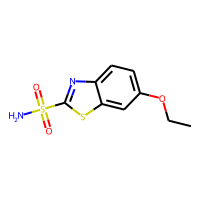
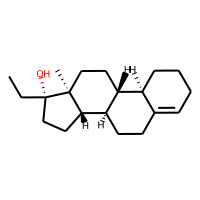
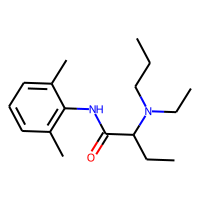
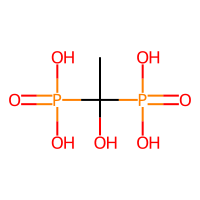
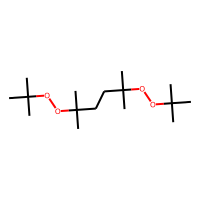

In [23]:
# Compute the descriptors
tox21['Descriptors'] = tox21['Molecule'].map(lambda x: computeDescriptors(x,calculator))
# Remove rows with non-finite descriptor values (seems to be only 1 by comparing the counts)
tox21 = tox21[tox21['Descriptors'].map(lambda x: x is not None)]
tox21.head()

In [24]:
df_descriptors = pd.DataFrame(descriptors, columns=['desc_name'])
df_descriptors

,desc_name
0,MaxEStateIndex
1,MinEStateIndex
2,MaxAbsEStateIndex
3,MinAbsEStateIndex
4,qed
...,...
203,fr_thiazole
204,fr_thiocyan
205,fr_thiophene
206,fr_unbrch_alkane


In [25]:
desc_name = [df_descriptors['desc_name'][i] for i in range(len(df_descriptors))]
desc_val = [list(l) for l in tox21['Descriptors']]
df_desc = pd.DataFrame(desc_val, index = tox21.index, columns=desc_name)
df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.107593,-3.723219,11.107593,0.073011,0.900283,258.324,248.244,258.013284,86,0,...,0,1,0,0,0,1,0,0,0,0
1,11.165775,-0.369724,11.165775,0.207144,0.666269,288.475,256.219,288.245316,118,0,...,0,0,0,0,0,0,0,0,0,0
2,12.570517,-0.042633,12.570517,0.042633,0.822261,276.424,248.200,276.220164,112,0,...,0,0,0,0,0,0,0,0,0,0
3,10.251875,-5.197724,10.251875,0.383488,0.365583,206.027,197.963,205.974526,68,0,...,0,0,0,0,0,0,0,0,0,0
4,5.538351,-0.365434,5.538351,0.306911,0.497486,290.444,256.172,290.245710,122,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_desc['group'] = tox21[['group']].copy()

In [27]:
df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,group
0,11.107593,-3.723219,11.107593,0.073011,0.900283,258.324,248.244,258.013284,86,0,...,1,0,0,0,1,0,0,0,0,train
1,11.165775,-0.369724,11.165775,0.207144,0.666269,288.475,256.219,288.245316,118,0,...,0,0,0,0,0,0,0,0,0,train
2,12.570517,-0.042633,12.570517,0.042633,0.822261,276.424,248.200,276.220164,112,0,...,0,0,0,0,0,0,0,0,0,train
3,10.251875,-5.197724,10.251875,0.383488,0.365583,206.027,197.963,205.974526,68,0,...,0,0,0,0,0,0,0,0,0,train
4,5.538351,-0.365434,5.538351,0.306911,0.497486,290.444,256.172,290.245710,122,0,...,0,0,0,0,0,0,0,0,0,train


In [28]:
#Finds Null data in any row if any
sample_incomplete_rows = df_desc[df_desc.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,group


In [29]:
df_desc.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.0,...,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000
mean,9.883089,-0.809776,9.883089,0.337003,0.547171,276.199693,258.091389,275.824271,101.869288,0.0,...,0.041140,0.033459,0.007942,0.005859,0.004166,0.015493,0.001692,0.012238,0.658508,0.029033
std,3.097393,1.584549,3.097393,0.483542,0.189120,165.062634,155.895703,164.902574,61.103239,0.0,...,0.231334,0.197774,0.093064,0.076322,0.066406,0.135572,0.044162,0.122288,2.310001,0.181331
min,1.500000,-9.769375,1.500000,0.000000,0.010404,30.026000,28.010000,30.010565,12.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.669537,-1.170285,8.669537,0.069009,0.427859,165.236000,153.524000,165.115364,62.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.686611,-0.426062,10.686611,0.184734,0.551698,240.266000,224.174000,240.034193,88.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.030946,0.152778,12.030946,0.421852,0.687891,342.439000,320.266000,342.116212,126.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.442653,4.000000,17.442653,8.764932,0.944994,1950.681000,1904.313000,1949.500417,704.000000,0.0,...,4.000000,2.000000,2.000000,1.000000,2.000000,4.000000,2.000000,3.000000,35.000000,4.000000


### Splitting and Visualizing the data

# Splite the data


In [30]:
categories = ['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP','SR-p53']
categories

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

## Feature Scaling

In [31]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

forest_clf = RandomForestClassifier(max_depth = 10, max_features = 'sqrt', min_impurity_decrease = 0, min_samples_leaf = 3, n_estimators = 1000,
 random_state = 42)

In [33]:
#load JS visualization code to notebook
shap.initjs()

Target: NR-AR


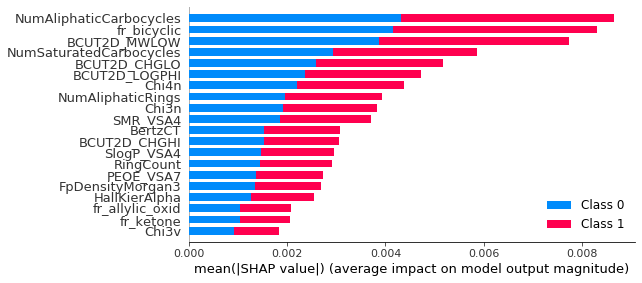

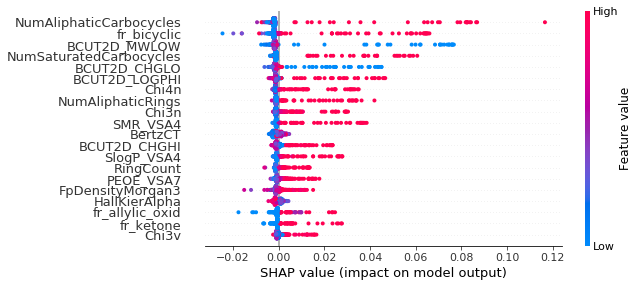

Target: NR-AR-LBD


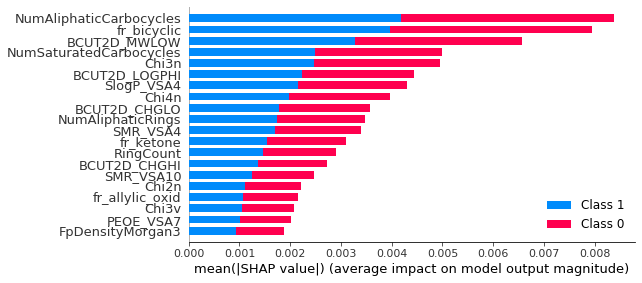

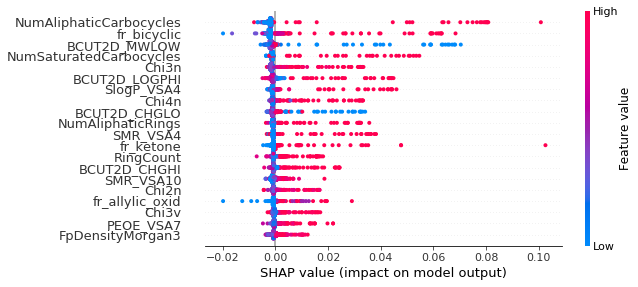

Target: NR-AhR


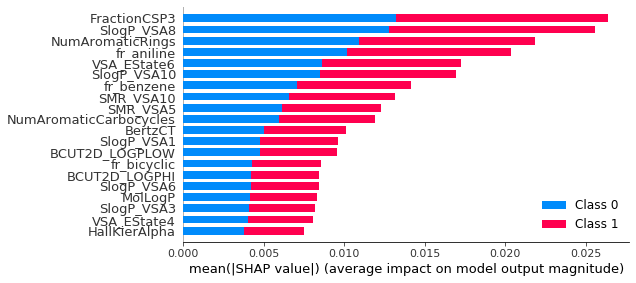

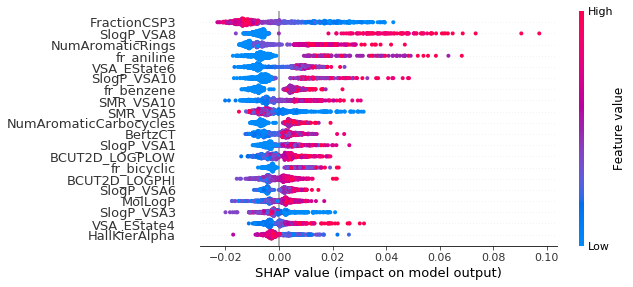

Target: NR-Aromatase


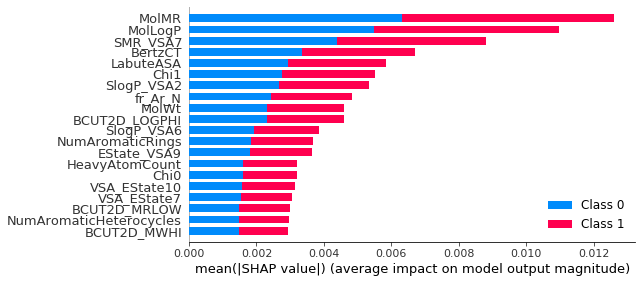

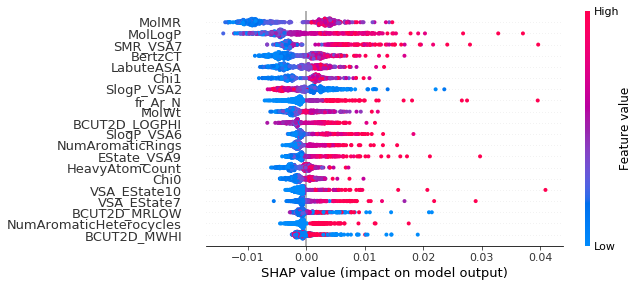

Target: NR-ER


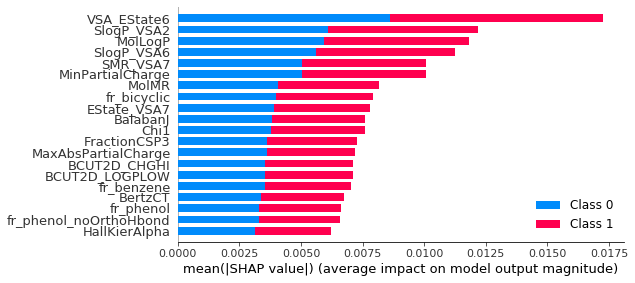

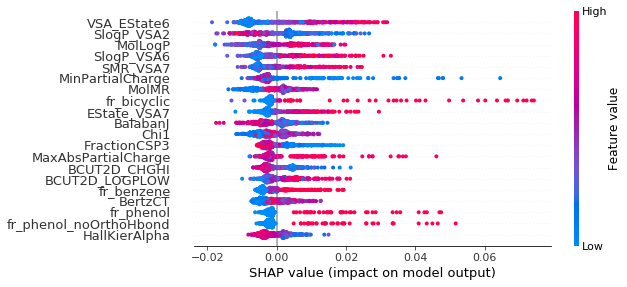

Target: NR-ER-LBD


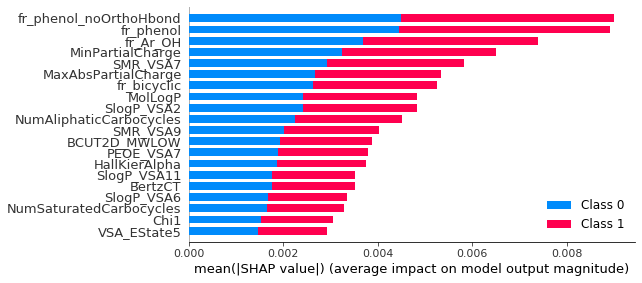

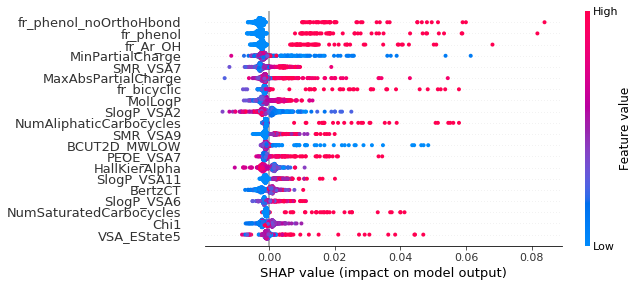

Target: NR-PPAR-gamma


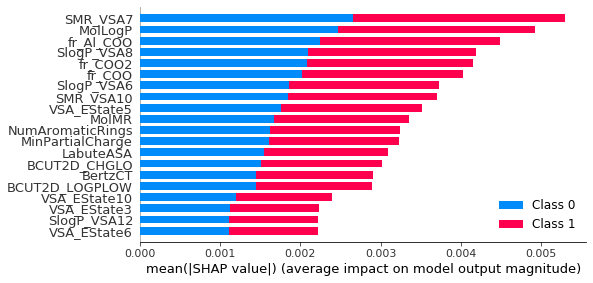

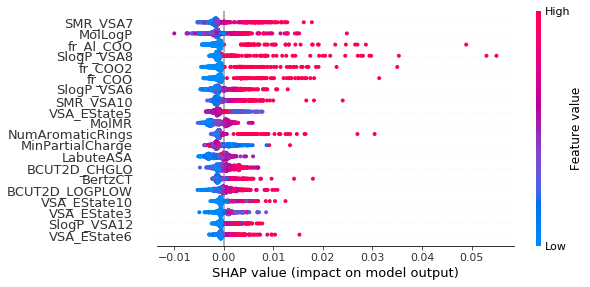

Target: SR-ARE


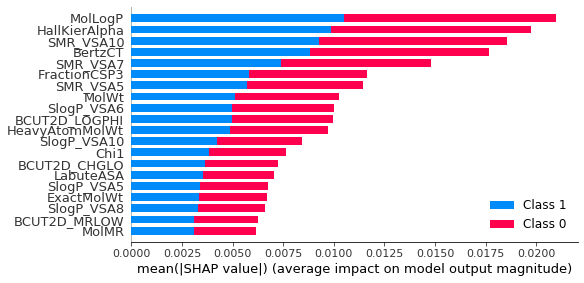

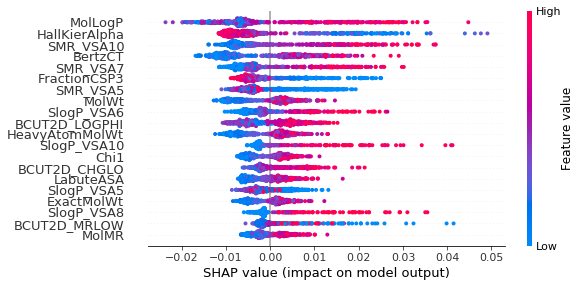

Target: SR-ATAD5


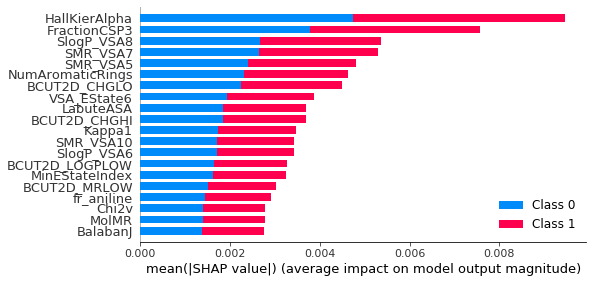

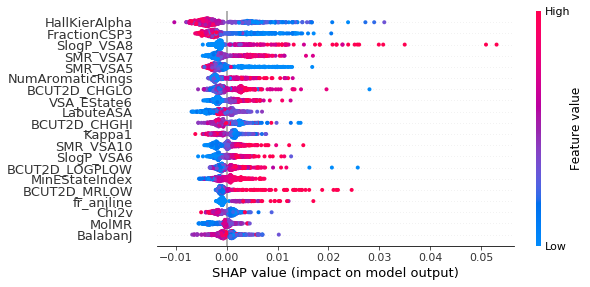

Target: SR-HSE


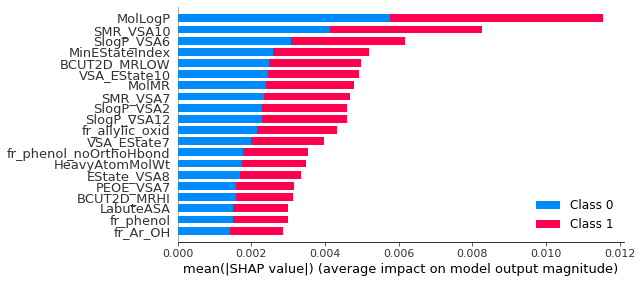

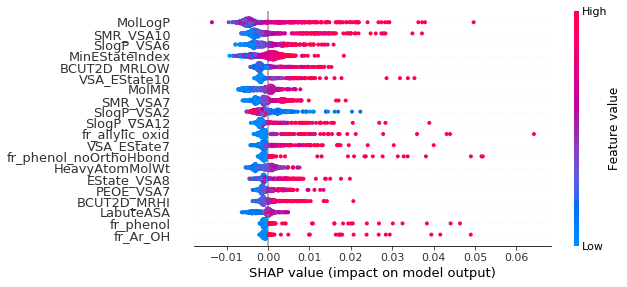

Target: SR-MMP


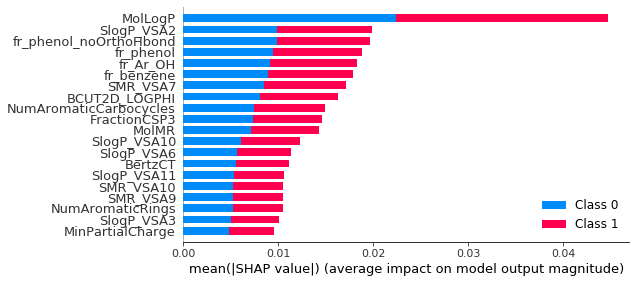

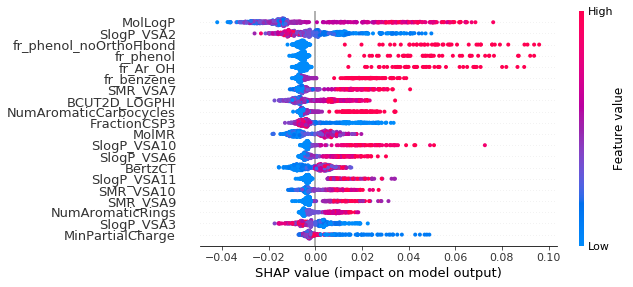

Target: SR-p53


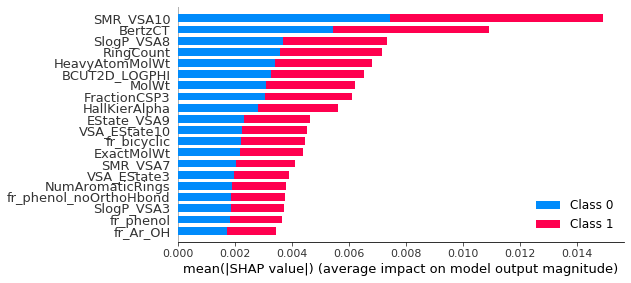

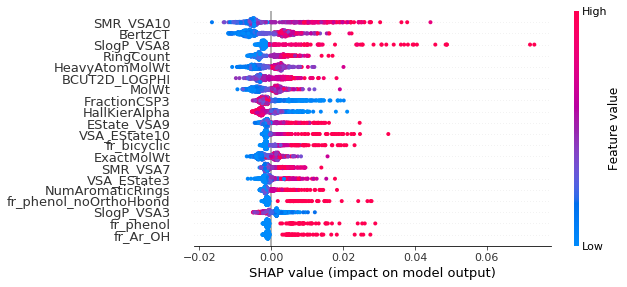

In [34]:
for category in categories:
    print(f"Target: {category}")
    X_train = df_desc[df_desc["group"]=="train"]
    y_train = tox21[tox21["group"]=="train"]
    X_train = X_train.drop(['group'], axis=1)
    y_train = y_train.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)
    y_train = y_train[category].dropna()
    y_train_ind = y_train.index
    X_train = X_train.loc[y_train_ind]
    
     
    X_valid = df_desc[df_desc["group"]=="valid"]
    y_valid = tox21[tox21["group"]=="valid"]
    X_valid = X_valid.drop(['group'], axis=1)
    y_valid = y_valid.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)
    y_valid = y_valid[category].dropna()
    y_valid_ind = y_valid.index
    X_valid = X_valid.loc[y_valid_ind]
    
  
    X_test = df_desc[df_desc["group"]=="test"]
    y_test = tox21[tox21["group"]=="test"]
    X_test = X_test.drop(['group'], axis=1)
    y_test = y_test.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)
    y_test = y_test[category].dropna()
    y_test_ind = y_test.index
    X_test = X_test.loc[y_test_ind]
    X_testCol = X_test.columns
    
    X_train = sc.fit_transform(X_train)
    X_valid = sc.transform(X_valid)
    X_test = sc.transform(X_test)

   
    # Training logistic regression model on train data
    model = forest_clf.fit(X_train, y_train)
    
    # calculating accuracy
    prediction_train = model.predict_proba(X_train)[:, 1]
    prediction_valid = model.predict_proba(X_valid)[:, 1]
    prediction_test = model.predict_proba(X_test)[:, 1]
    
    # explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    
    # visualize the first prediction's explanation
    plt.subplot(211)
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = X_testCol)
        
    # A standard bar plot for the mean absolute value of the SHAP values for each feature
    plt.subplot(212)
    shap.summary_plot(shap_values[1], X_test, feature_names = X_testCol)
    
    

In [35]:
print("Done")

Done
